In [92]:
#library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import solve_ivp

In [84]:
#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small  ## WHAT IS THIS
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)

In [85]:
N0 = [ # list of initial population densities
    1e-3, # species 1
    2e-3, # species 2
    1e-4, # species 3
    1e-5  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [86]:
#simplified model
def CR_model_simple(t, y):
  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])
  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([J[i, a] for a in range(n_cs)])
    print(growth_intake, R[0])
    dNdt[i] = (N[i]*growth_intake)-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    dRdt[a] = (R0[a]-R[a])*d - consumption

  return np.concatenate((dNdt,dRdt))

In [87]:
# complete model
def CR_model(t, y):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])

  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)])
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    byproduction_tot = np.zeros((n_species, n_cs))
    for i in range(n_species):
      for b in range(n_cs):
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a]
    byproduction = np.sum(byproduction_tot)
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction

  return np.concatenate((dNdt,dRdt))

In [88]:
t_span = (0,300)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [89]:
#solution of the model
solutions = solve_ivp(CR_model, t_span, y0, method = "BDF")

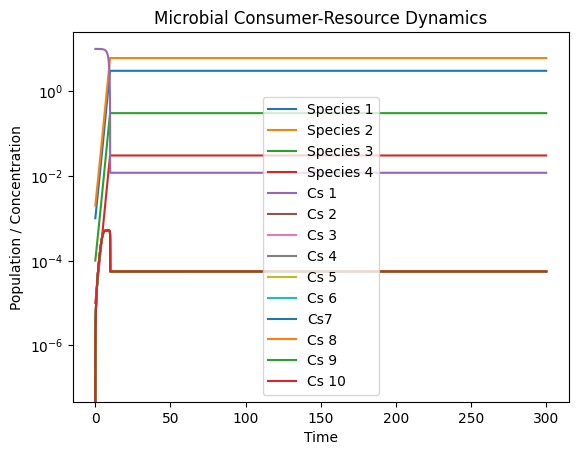

In [71]:
plt.plot(solutions.t, solutions.y[0], label='Species 1')
plt.plot(solutions.t, solutions.y[1], label='Species 2')
plt.plot(solutions.t, solutions.y[2], label='Species 3')
plt.plot(solutions.t, solutions.y[3], label='Species 4')
plt.plot(solutions.t, solutions.y[4], label='Cs 1')
plt.plot(solutions.t, solutions.y[5], label='Cs 2')
plt.plot(solutions.t, solutions.y[6], label='Cs 3')
plt.plot(solutions.t, solutions.y[7], label='Cs 4')
plt.plot(solutions.t, solutions.y[8], label='Cs 5')
plt.plot(solutions.t, solutions.y[9], label='Cs 6')
plt.plot(solutions.t, solutions.y[10], label='Cs7')
plt.plot(solutions.t, solutions.y[11], label='Cs 8')
plt.plot(solutions.t, solutions.y[12], label='Cs 9')
plt.plot(solutions.t, solutions.y[13], label='Cs 10')
plt.yscale("log")
plt.title('Microbial Consumer-Resource Dynamics')
plt.xlabel('Time')
plt.ylabel('Population / Concentration')
plt.legend()
plt.show()

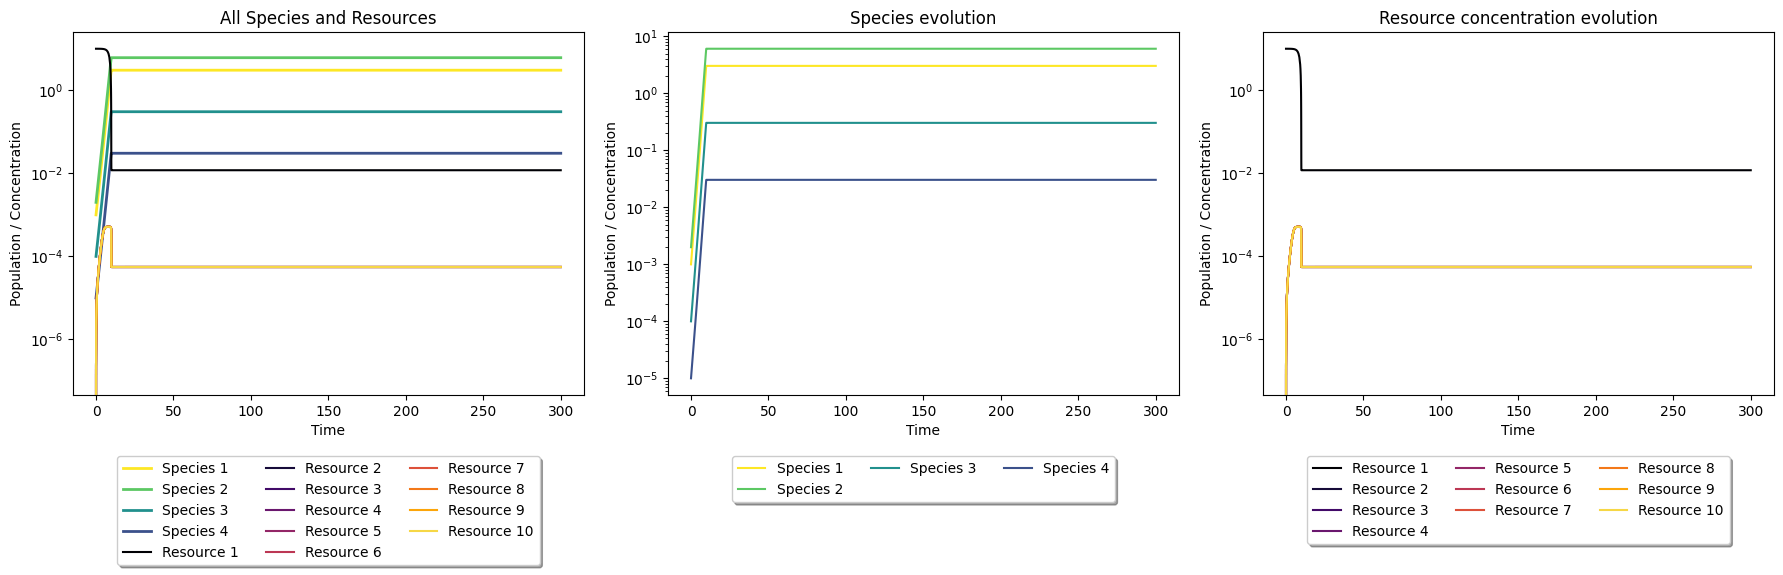

In [110]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
#Randomisation of some parameters

c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)

In [ ]:
solutions2 = solve_ivp(CR_model, t_span, y0, method = "BDF")

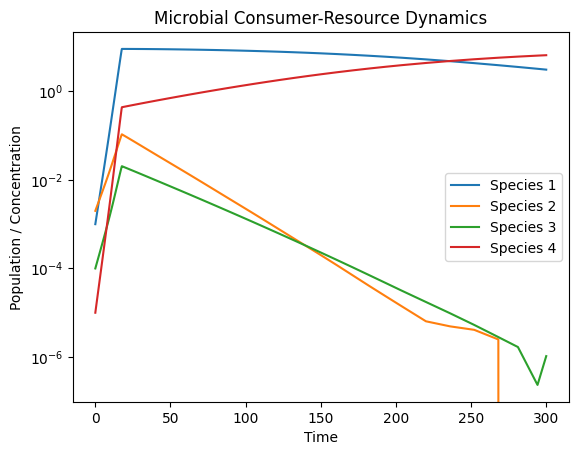

In [94]:
plt.plot(solutions2.t, solutions2.y[0], label='Species 1')
plt.plot(solutions2.t, solutions2.y[1], label='Species 2')
plt.plot(solutions2.t, solutions2.y[2], label='Species 3')
plt.plot(solutions2.t, solutions2.y[3], label='Species 4')
#plt.plot(solutions2.t, solutions2.y[4], label='Cs 1')
#plt.plot(solutions2.t, solutions2.y[5], label='Cs 2')
#plt.plot(solutions2.t, solutions2.y[6], label='Cs 3')
#plt.plot(solutions2.t, solutions2.y[7], label='Cs 4')
#plt.plot(solutions2.t, solutions2.y[8], label='Cs 5')
#plt.plot(solutions2.t, solutions2.y[9], label='Cs 6')
#plt.plot(solutions2.t, solutions2.y[10], label='Cs7')
#plt.plot(solutions2.t, solutions2.y[11], label='Cs 8')
#plt.plot(solutions2.t, solutions2.y[12], label='Cs 9')
#plt.plot(solutions2.t, solutions2.y[13], label='Cs 10')
plt.yscale("log")
plt.title('Microbial Consumer-Resource Dynamics')
plt.xlabel('Time')
plt.ylabel('Population / Concentration')
plt.legend()
plt.show()

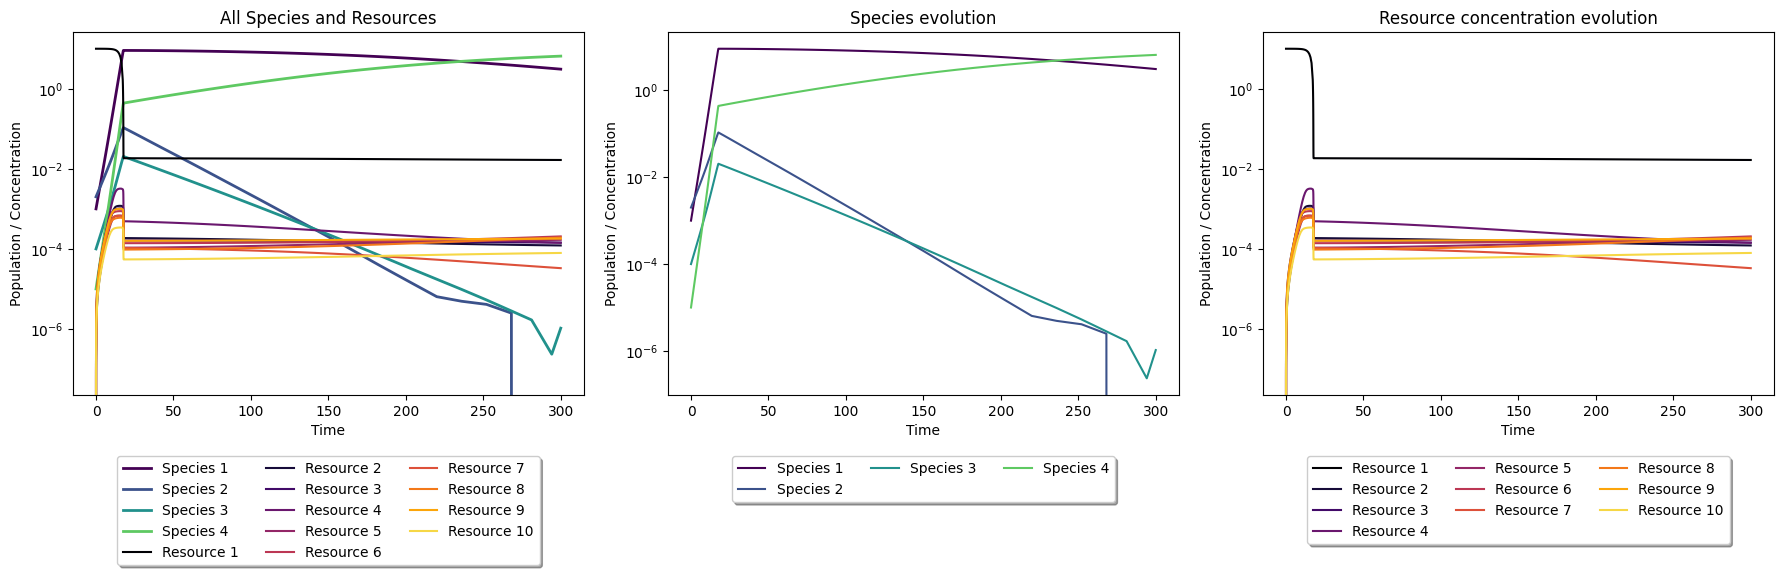

In [111]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()